In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip install datasets transformers huggingface_hub

In [3]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [4]:
!pip install --upgrade datasets huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.35.3
    Uninstalling huggingface-hub-0.35.3:
      Successfully uninstalled huggingface-hub-0.35.3
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "

In [5]:
from datasets import load_dataset
imdb = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [25]:
small_train_dataset = imdb['train'].shuffle(seed=42).select([i for i in list (range(3000))])
small_test_train = imdb['test'].shuffle(seed=42).select([i for i in list(range(300))])

In [7]:
#Tokenzier
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [26]:
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_train.map(preprocess_function, batched=True)

In [10]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [27]:
import numpy as np
#from datasets import load_metric
import evaluate

metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_accuracy.compute(predictions=preds, references=labels)['accuracy']
    f1 = metric_f1.compute(predictions=preds, references=labels, average='binary')['f1']
    precision = metric_precision.compute(predictions=preds, references=labels, average='binary')['precision']
    recall = metric_recall.compute(predictions=preds, references=labels, average='binary')['recall']

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [28]:
from transformers import TrainingArguments, Trainer

output_dir = "/content/drive/MyDrive/sentiment"

training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 2,
    weight_decay = 0.01,
    save_strategy = "epoch",
    ##
    report_to="none",
    logging_dir = None,
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

/tmp/ipython-input-3970184498.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=376, training_loss=0.20540152204797624, metrics={'train_runtime': 274.7394, 'train_samples_per_second': 21.839, 'train_steps_per_second': 1.369, 'total_flos': 782725021021056.0, 'train_loss': 0.20540152204797624, 'epoch': 2.0})

In [30]:
trainer.evaluate()

{'eval_loss': 0.36724135279655457,
 'eval_accuracy': 0.8833333333333333,
 'eval_f1': 0.8852459016393442,
 'eval_precision': 0.8709677419354839,
 'eval_recall': 0.9,
 'eval_runtime': 3.9302,
 'eval_samples_per_second': 76.331,
 'eval_steps_per_second': 4.834,
 'epoch': 2.0}

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(trainer, test_dataset):
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=-1)
    labels = test_dataset["label"]

    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - IMDB Sentiment Analysis")
    plt.show()

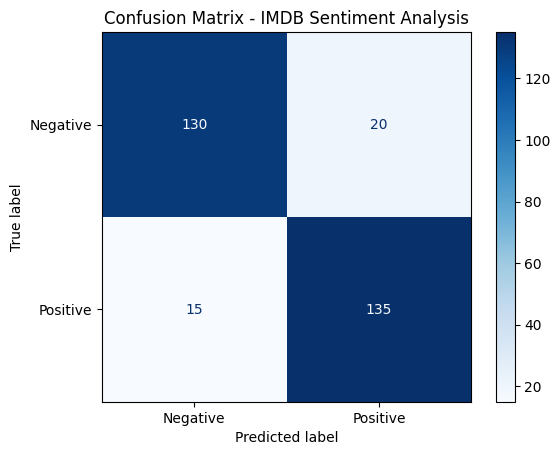

In [36]:
plot_confusion(trainer, test_dataset=tokenized_test)

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment/checkpoint-188")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/sentiment/checkpoint-188")


In [52]:
import torch
import numpy as np

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    return {
        "label": "Positive" if predicted_class == 1 else "Negative",
        "confidence": round(probabilities[0][predicted_class].item(), 4)
    }


In [58]:
text = input("Nhập câu cần phân tích: ")
result = predict(text)
print("Predicted label:", result["label"])
print("Confidence:", result["confidence"])


Nhập câu cần phân tích: you look pretty
Predicted label: Positive
Confidence: 0.8645
